# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()
# mpld3.disable_notebook()

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import models

In [3]:
import os
import yaml
import boto3
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import albumentations
import segmentation_models_pytorch as smp

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
(device,
 torch.__version__,
 torchvision.__version__,
 smp.__version__,
 matplotlib.__version__,
 albumentations.__version__)

(device(type='cuda'), '1.5.1', '0.6.1', '0.1.0', '3.2.2', '0.4.5')

In [5]:
config = yaml.load(open('config/config.yml'), Loader=yaml.BaseLoader)
# config

In [6]:
os.environ['AWS_ACCESS_KEY_ID'] = config['aws']['aws_access_key_id']
os.environ['AWS_SECRET_ACCESS_KEY'] = config['aws']['aws_secret_access_key']
os.environ['AWS_DEFAULT_REGION'] = config['aws']['aws_default_region']
s3 = boto3.client('s3')

In [7]:
am_segm_bucket = 'am-segm'
# model_path = 'model/unet-dan.pt'
model_path = 'model/model-dhb.pt'

# Train Model

In [11]:
import pandas as pd
from sklearn.model_selection import GroupKFold, KFold
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import albumentations as albu
import sagemaker

from am.segment.dataset import (
    AMDataset, create_ds, create_dl,
    train_transform, valid_transform, default_transform
)
from am.segment.loss import jaccard, CombinedLoss
from am.segment.model import UNet11, AlbuNet, UNet16
from am.segment.train import train_loop
from am.segment.image_utils import save_rgb_image, overlay_source_mask, normalize, read_image
from am.segment.visual import convert_to_image, predict_plot, create_uniq_exp_group, plot_images_grid
from am.utils import save_model, load_model

In [22]:
sagemaker_session = sagemaker.Session()
sagemaker_session.download_data('data/DHB', 'am-segm', 'training-data-dhb/train')

In [66]:
batch_size = 4
# train_paths = list(Path('data/DHB/train').iterdir())
train_paths = [
    'data/DHB/train/2020-09-02_t1_z1_c0_dapi',
#     'data/DHB/DHB_ds2/manual_tiles',
#     'data/DHB/17_A_A2_bis-crop/manual_tiles',
#     'data/DHB/DHB_Crops_of_mouse_7-8/manual_tiles',
#     'data/DHB/drugs_2/manual_tiles',
]
train_dl = create_dl(
    train_paths,
    transform=train_transform(),
    path_image_n=16, shuffle=True, batch_size=batch_size
)

# valid_paths = [
#     'data/DHB/2020-09-02_t1_z1_c0_dapi/manual_tiles_valid',
# ]
valid_paths = list(Path('data/DHB/valid').iterdir())
valid_dl = create_dl(
    valid_paths,
    transform=valid_transform(),
    path_image_n=16, shuffle=False, batch_size=batch_size*2
#     path_image_n=8, shuffle=False, batch_size=batch_size*2
)
len(train_dl.dataset), len(valid_dl.dataset)

Loading data from ['data/DHB/train/2020-09-02_t1_z1_c0_dapi'] paths
Loading data from [PosixPath('data/DHB/valid/2020-09-02_t1_z1_c0_dapi')] paths


(16, 16)

In [67]:
train_uniq_exp_group = create_uniq_exp_group(train_dl)
valid_uniq_exp_group = create_uniq_exp_group(valid_dl)
train_valid_intersection = train_uniq_exp_group.intersection(valid_uniq_exp_group)
if train_valid_intersection:
    print(f"(!) Train and valid groups overlap: {train_valid_intersection}")

data/DHB/train/2020-09-02_t1_z1_c0_dapi/well3/source/0102.png data/DHB/train/2020-09-02_t1_z1_c0_dapi/well3/mask/0102.png


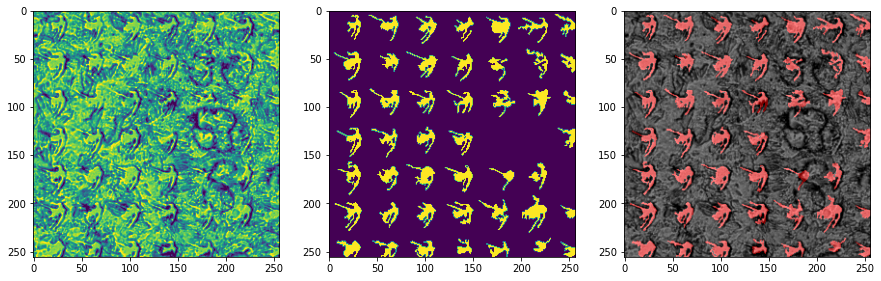

In [68]:
image_path = train_dl.dataset.image_df.iloc[2].path
mask_path = train_dl.dataset.mask_df.iloc[2].path
print(image_path, mask_path)

image = read_image(image_path, ch_n=1)
mask = read_image(mask_path)

overlay = overlay_source_mask(image, mask, alpha=0.5)

plot_images_grid([image, mask, overlay], ncols=3)

In [69]:
image, mask = valid_dl.dataset[3]
image = convert_to_image(image)
mask = convert_to_image(mask)
image.shape, mask.shape

((512, 512, 3), (512, 512))

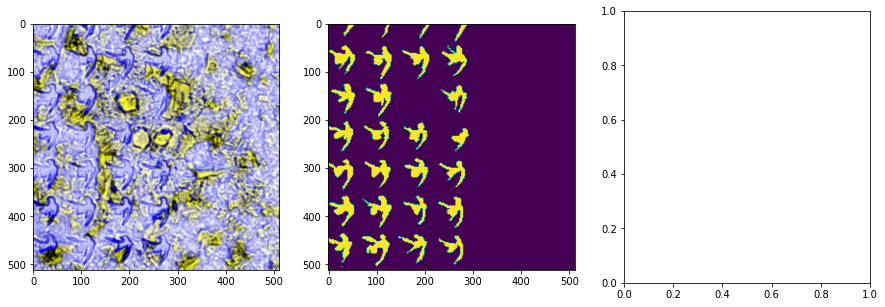

In [70]:
plot_images_grid([image, mask])

## Visualize Images

Train data


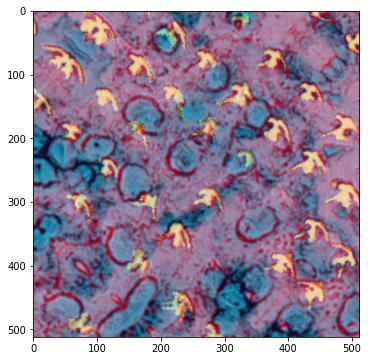

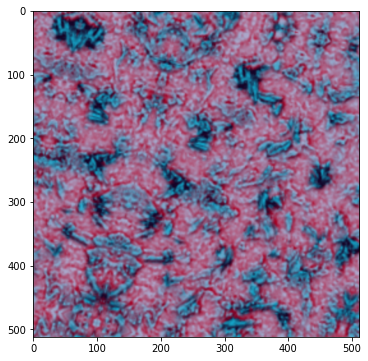

Valid data


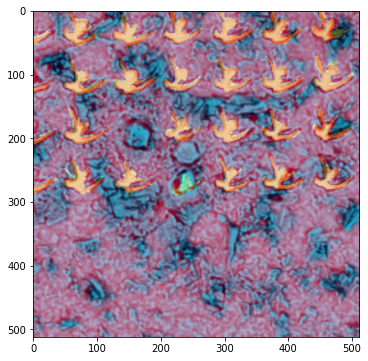

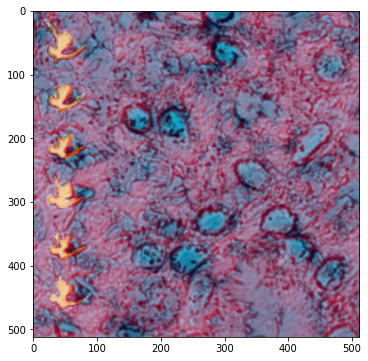

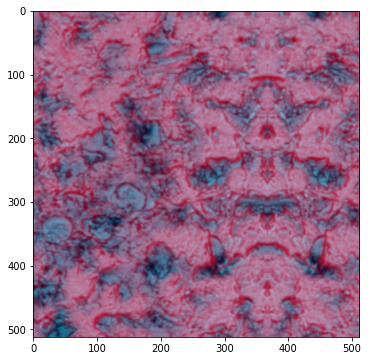

In [80]:
print('Train data')
n = 2
rinds = np.random.randint(0, len(train_dl.dataset), n)
for i in rinds:
    img, mask = train_dl.dataset[i]
#     img_no_tfm, _ = train_no_tfm_ds[i]
    fig = plot_overlay(img, mask, figsize=(6, 6))
#     fig = plot_images_row([img_no_tfm, img])
    plt.show()
#     if i == n - 1: break
    
print('Valid data')
n = 3
for i, (img, mask) in enumerate(valid_dl.dataset):
    plot_overlay(img, mask, figsize=(6, 6))
    plt.show()
    if i == n - 1: break

## Train

In [71]:
import math
from am.segment.train import convert_history_to_tuple
from am.segment.visual import plot_loss_metric, save_history_overlay, plot_images_grid

In [31]:
n_epochs = 10
lr_dec_1 = 3e-2
lr_enc_2 = 3e-4

model = smp.Unet(encoder_name='se_resnext50_32x4d', decoder_use_batchnorm=True)
criterion = CombinedLoss(bce_weight=0.5, jaccard=True, smooth=1e-15)

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': lr_dec_1},
])
history = train_loop(model, train_dl, valid_dl, optimizer, criterion, n_epochs)

optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters(), 'lr': lr_enc_2},
    {'params': model.decoder.parameters(), 'lr': lr_dec_1 / 10},
])
history += train_loop(model, train_dl, valid_dl, optimizer, criterion, n_epochs=n_epochs)

optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters(), 'lr': lr_enc_2 / 10},
    {'params': model.decoder.parameters(), 'lr': lr_dec_1 / 100},
])
history += train_loop(model, train_dl, valid_dl, optimizer, criterion, n_epochs=n_epochs)

history_tuple = convert_history_to_tuple(history)

Starting training loop. Using cuda device
Epoch 1/10
----------
............................
Train loss: 1.12344, train metric: 0.34165
.
Valid loss: 2.32822, valid metric: 0.08459
Saving best model as "best_model.pt"
0 min 41 sec
Epoch 2/10
----------
............................
Train loss: 0.68556, train metric: 0.43821
.
Valid loss: 0.86529, valid metric: 0.28345
Saving best model as "best_model.pt"
1 min 21 sec
Epoch 3/10
----------
............................
Train loss: 0.56077, train metric: 0.44196
.
Valid loss: 0.78655, valid metric: 0.24885
2 min 1 sec
Epoch 4/10
----------
............................
Train loss: 0.45433, train metric: 0.49321
.
Valid loss: 0.90285, valid metric: 0.17104
2 min 41 sec
Epoch 5/10
----------
............................
Train loss: 0.40632, train metric: 0.52452
.
Valid loss: 0.66078, valid metric: 0.28288
3 min 20 sec
Epoch 6/10
----------
............................
Train loss: 0.36753, train metric: 0.53090
.
Valid loss: 0.60921, valid me

In [88]:
# # FINE TUNING

# n_epochs = 5
# lr = 3e-4

# model = load_model(model_path)
# criterion = CombinedLoss(bce_weight=0.5, jaccard=True, smooth=1e-15)

# optimizer = torch.optim.Adam([
#     {'params': model.encoder.parameters(), 'lr': lr},
#     {'params': model.decoder.parameters(), 'lr': lr},
# ])
# history = train_loop(model, train_dl, valid_dl, optimizer, criterion, n_epochs=n_epochs)

# # optimizer = torch.optim.Adam([
# #     {'params': model.encoder.parameters(), 'lr': lr / 3},
# #     {'params': model.decoder.parameters(), 'lr': lr / 3},
# # ])
# # history += train_loop(model, train_dl, valid_dl, optimizer, criterion, n_epochs=n_epochs)

# history_tuple = convert_history_to_tuple(history)

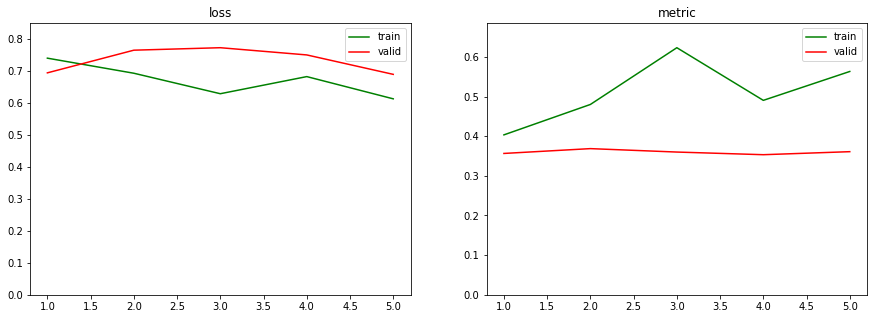

In [83]:
plot_loss_metric(history_tuple)

2


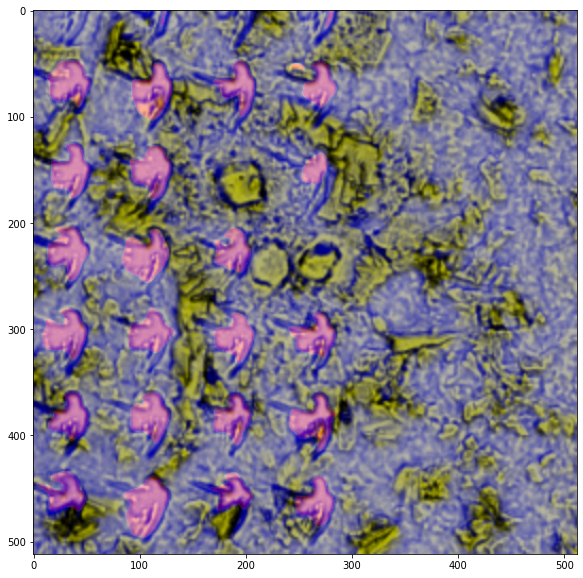

In [84]:
best_idx = history_tuple.valid_metric.argmax()
print(best_idx + 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(history_tuple.overlay[best_idx]);

In [87]:
# titles = [
#     f'{i}: loss={l:.3f} metric={m:.3f}'
#     for i, (l, m) in enumerate(zip(history_tuple.valid_loss, history_tuple.valid_metric), start=1)
# ]
# plot_images_grid(history_tuple.overlay, titles=titles)

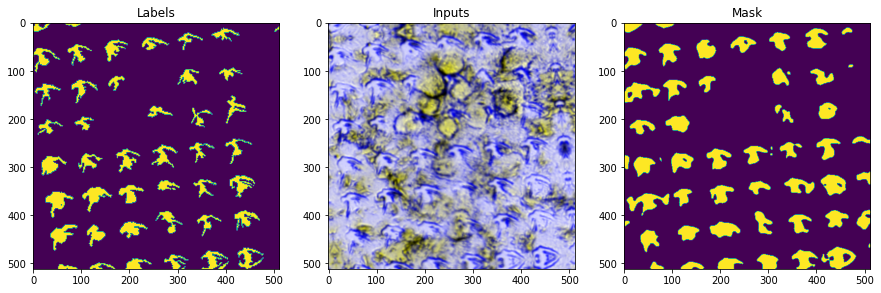

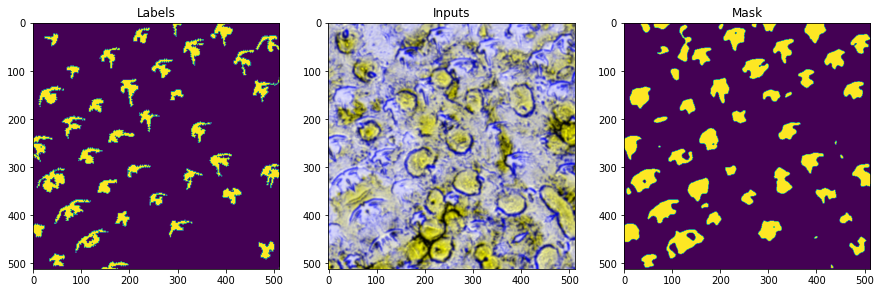

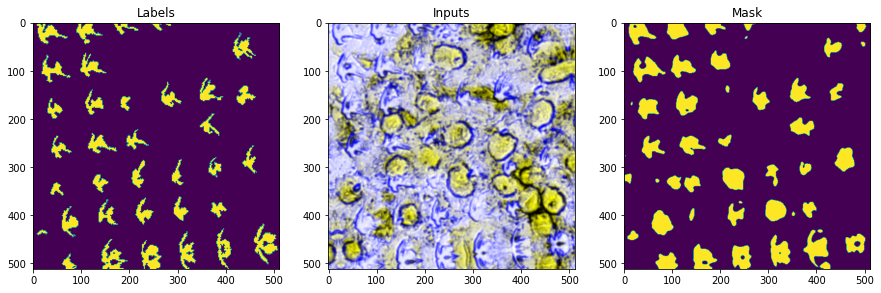

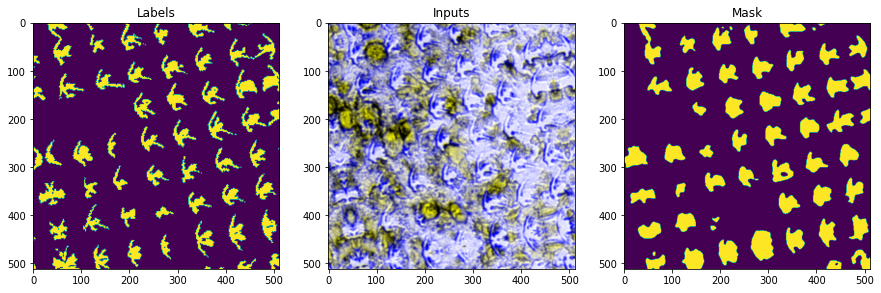

In [85]:
predict_plot(model, train_dl, n=4)

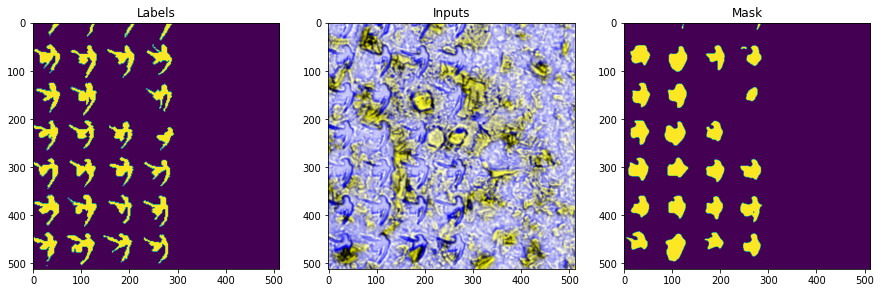

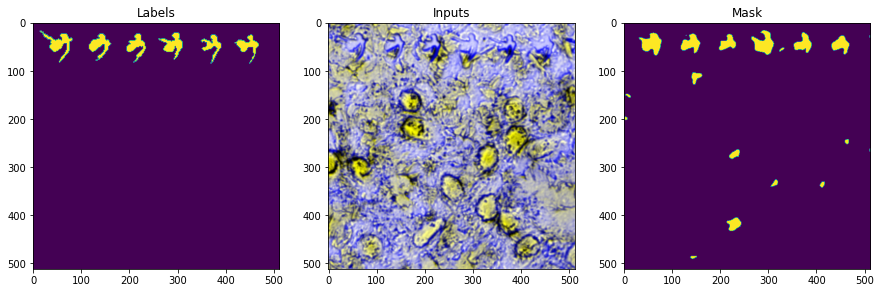

/home/ubuntu/am_segm/am/segment/image_utils.py:117: RuntimeWarning: invalid value encountered in true_divide
  (img - img.min(axis=(0, 1))) / (img.max(axis=(0, 1)) - img.min(axis=(0, 1))) * 255


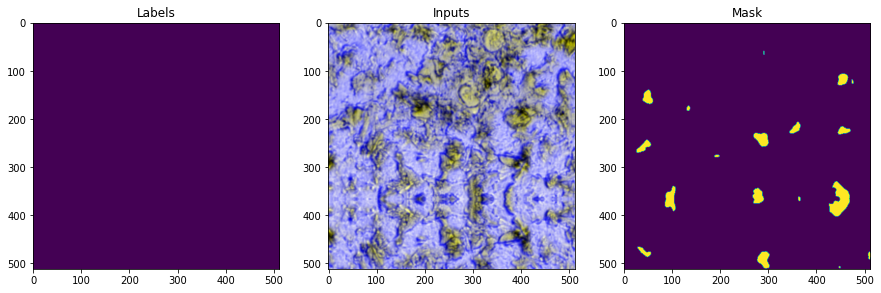

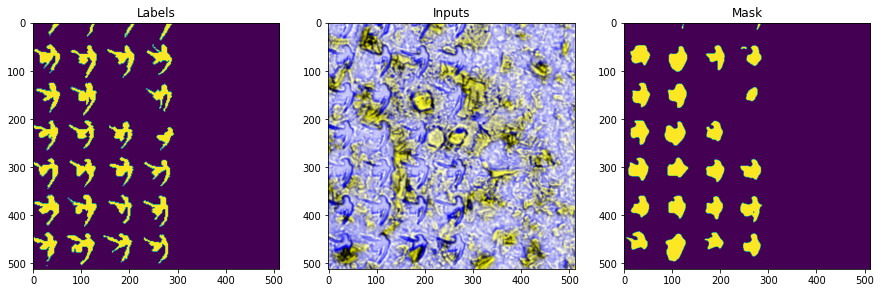

In [86]:
predict_plot(model, valid_dl, n=4)

In [ ]:
save_model(model, model_path)
s3.upload_file(model_path, am_segm_bucket, model_path)

# Predict

In [168]:
from am.utils import load_model

In [169]:
model = load_model(model_path)

In [172]:
test_dl = create_dl(
    ['data/DHB/drugs_2/tiles'],
    transform=valid_transform(),
    path_image_n=16,
    batch_size=8
)
len(test_dl.dataset)

16

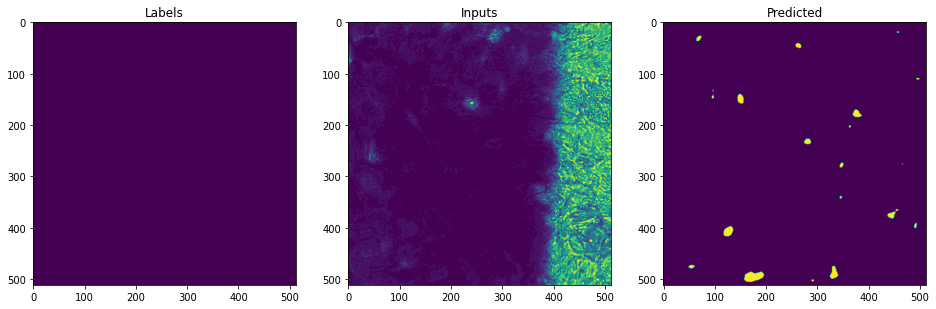

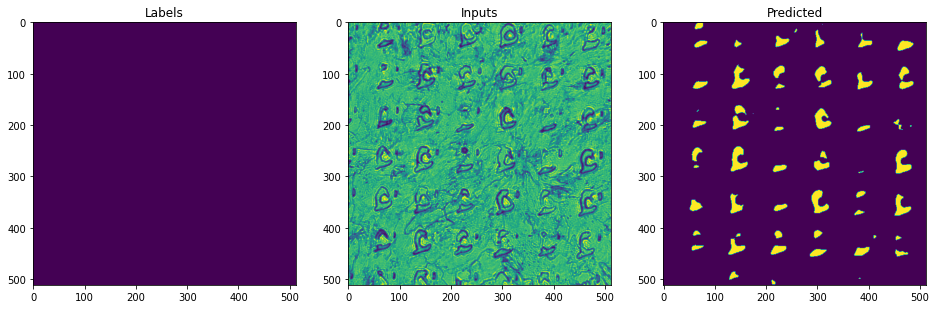

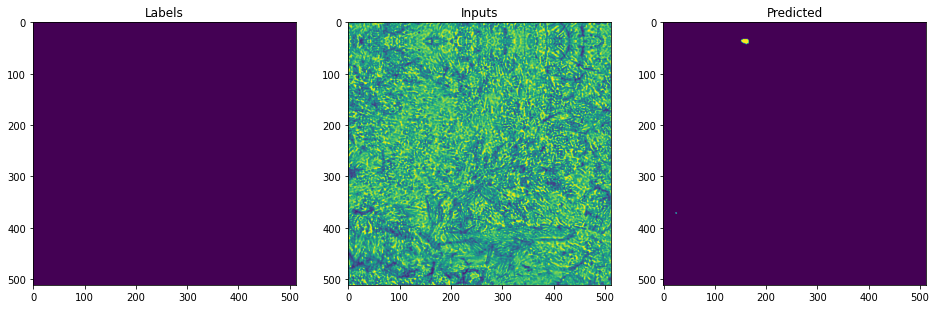

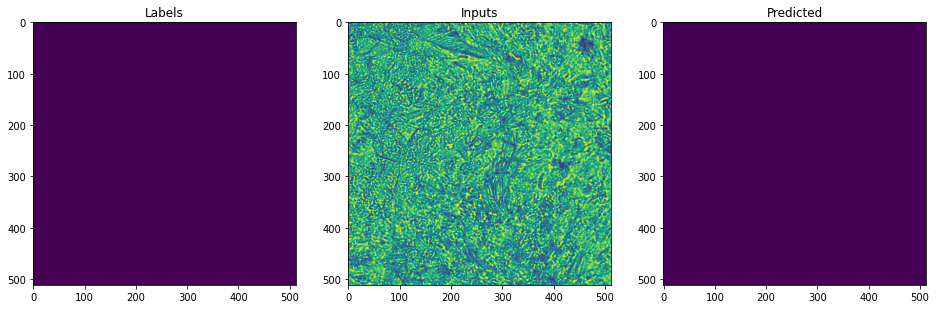

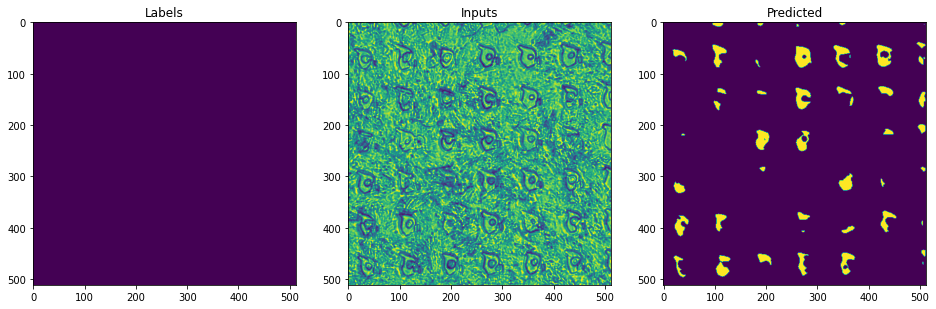

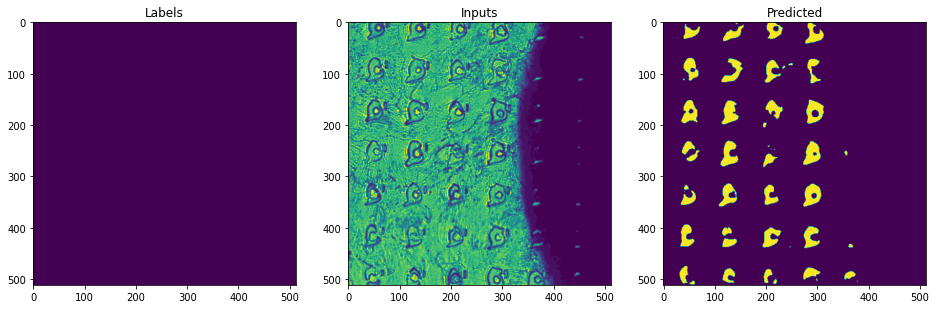

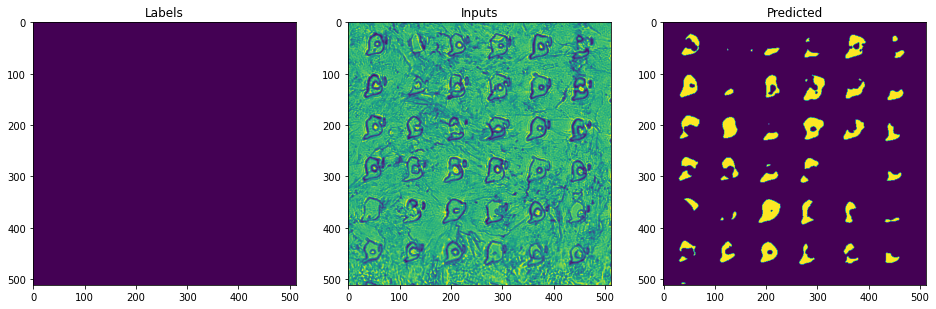

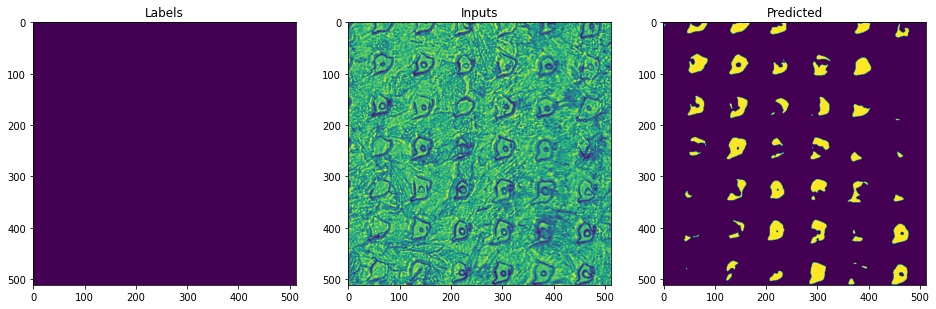

In [173]:
predict_plot(model, test_dl)

# Save Predictions

In [183]:
import json
from shutil import copy, rmtree
from am.utils import read_image, save_overlay
from am.segment.predict import predict_save
from am.segment.preprocess import stitch_tiles_at_path, overlay_images_with_masks

In [184]:
valid_ds_path

PosixPath('data/Mouse_16_slideD_DAN_FD_stained_left_BF')

In [185]:
ds = load_ds(valid_ds_path / 'tiles', valid_transform())
predict_save(model, ds, pred_path=valid_ds_path / 'pseudo_tiles')

Well7 batches processed
Well3
Well7
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/000.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/000.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/001.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/001.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/002.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/002.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/003.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/003.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/004.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/004.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/005.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/005.png
data/Mouse_16_slideD_DAN_FD_stained_left

data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/078.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/078.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/079.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/079.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/080.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/080.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/081.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/081.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/082.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/082.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/083.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/083.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/084.pn

data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/156.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/157.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/157.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/158.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/158.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/159.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/159.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/160.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/160.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/161.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/161.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/source/162.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well7/mask/162.png


data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/010.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/010.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/011.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/011.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/012.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/012.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/013.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/013.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/014.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/014.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/015.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/015.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/016.pn

data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/063.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/064.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/064.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/065.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/065.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/066.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/066.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/067.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/067.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/068.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/068.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/069.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/069.png


data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/142.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/143.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/143.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/144.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/144.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/145.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/145.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/146.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/146.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/147.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/147.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/148.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/148.png


data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/196.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/196.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/197.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/197.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/198.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/198.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/199.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/199.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/200.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/200.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/201.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/mask/201.png
data/Mouse_16_slideD_DAN_FD_stained_left_BF/pseudo_tiles/Well3/source/202.pn

In [186]:
for group_path in (valid_ds_path / 'tiles').iterdir():
    meta = json.load(open(group_path / 'meta.json'))
    break
meta

{'orig_image': {'h': 12816, 'w': 8177},
 'image': {'h': 7680, 'w': 4900},
 'tile': {'rows': 15, 'cols': 15, 'size': 512}}

In [187]:
stitch_tiles_at_path(
    valid_ds_path / 'pseudo_tiles',
    overwrite=True,
    meta=meta,
)

In [188]:
overlay_images_with_masks(valid_ds_path / 'tiles_stitched')

# TTA Experiments

In [ ]:
import albumentations.augmentations.functional as F
from albumentations.pytorch.transforms import img_to_tensor

In [ ]:
normalize = albu.Normalize(p=1)

In [ ]:
i = 13
image_path = valid_ds.image_df.iloc[i].path
image = cv2.imread(str(image_path))
image.shape

In [ ]:
plt.imshow(image)

In [ ]:
# plt.imshow(F.hflip(image))

In [ ]:
plt.imshow(normalize.apply(image))

In [ ]:
# tta_tfm = [lambda im: im, F.hflip, F.vflip, lambda im: F.vflip(F.hflip(im))]
# tta_tfm = [
#     lambda im: im,
#     lambda im: albu.CLAHE()(image=im)['image']
# ]

# for _ in range(5):
#     plt.imshow(tfm.apply(image)[:,:,0])
#     plt.show()

In [ ]:

tensors = [img_to_tensor(normalize.apply(tfm.apply(image)['image'])) for tfm in tta_tfm]

In [ ]:
batch = torch.stack(tensors)
batch.shape

In [ ]:
probs = torch.sigmoid(model(batch.to('cuda')))
probs.shape

In [ ]:
# plt.imshow(convert_to_image(probs[0]))

In [ ]:
# plt.imshow(F.hflip(convert_to_image(probs[1])))

In [ ]:
pred_masks = [convert_to_image(prob) for prob in probs]
pred_mask_mean = np.mean(pred_masks, axis=0)
pred_mask_mean.shape

In [ ]:
image.shape

In [ ]:
fig = plot_images_row([image[:,:,0], pred_masks[0] > 0.5, pred_masks[1] > 0.5, pred_mask_mean > 0.5])